# TODO

* Run mouse max-d analysis for the mouse data without changes-of-mind
* Run RT analysis for mouse data
* Run max-d and RT analyses for cleaned walking data
* Run frequentist regressions

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Lambda$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 
* Check sensitivity of max-d/RT to $\Lambda$ separately for high and low discounters. Most participants are high discounters, and for them almost all decisions are equally easy, so max-d wouldn't depend on $\Lambda$. However, for someone with a more balanced distribution of SS/LL choices, we would expect this effect.

# What's done:
- Ran mouse max-d without change-of-mind.
- Ran mouse RT for all types.
- Ran walking max-d without change-of-mind.
- Ran walking RT for all types.

Load needed libraries

In [22]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)

Load processed data

In [30]:
get_processed_data <- function(){
    filename <- "C:/Users/Arkady/Google Drive/data/beyond_the_reach/choices_processed.txt"
#     filename <- "../data/choices_processed.txt"
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])
    data[, 'option_chosen'] <- factor(data[, 'option_chosen'])
    
    return(data)
}

In [31]:
data <- get_processed_data()

In [32]:
nrow(data)/94

[1] 51.53191

Here, I have 2 sets of data for mouse/walking:
one with all trials, one with CoM trials excluded.

In [41]:
data <- get_processed_data()
mouse_data <- data[data$task=='mouse',]


# discarding missing values
mouse_data <- mouse_data[complete.cases(mouse_data[ , 'max_d']),]
mouse_data_no_com <- mouse_data[mouse_data$is_com=='False',]

walking_data <- data[data$task=='walking',]
walking_data <- walking_data[complete.cases(walking_data[ , 'max_d']),]
walking_data_no_com <- walking_data[walking_data$is_com=='False',]

In [34]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter))
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior)
    }
    return(model)
}

run_analysis <- function(var, data, rscale){
    " This function runs our analysis for a particular dataset (fake or real) and given DV (var).
    The rscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, var])/sd(data[, 'Lambda'])), class = "b"))

    formulas <- list(f_inter = as.formula(paste(var, "~ (option_chosen | subj_id) + Lambda:option_chosen")),
                     f_choice = as.formula(paste(var, "~ (option_chosen | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    return(bf_result)
}

# Mouse data: max-d without change-of-mind

In [35]:
# rt_bf <- run_analysis('RT', mouse_data, 0.707)
# max_d_bf <- run_analysis('max_d', mouse_data, 0.707)

max_d_bf <- run_analysis('max_d', mouse_data_no_com, 0.707)


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '31974588aee112e6d7d85ce4f8ad66c6' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000242 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.42 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 24.2082 seconds (Warm-up)
Chain 1:                12.8408 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '9b7519567c0a170991c10f704a4fe83d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000206 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.06 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 21.8493 seconds (Warm-up)
Chain 1:                14.8352 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '9e0af3661ba6cb6675a9f691ecc5207a' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000136 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.36 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.99731 seconds (Warm-up)
Chain 1:                3.62106 seconds (Sampling)
C

In [36]:
max_d_bf$bf

[,1]        [,2]        [,3]       
[1,] 6.18114e+57 5.08519e+55 0.007827133

In [37]:
spaghetti <- function(model, var, ylabel){
    plt_dat <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=800), plot=FALSE)
    plt_dat <- plt_dat$"Lambda:option_chosen" + 
#         geom_point(aes_string(x="Lambda", y=var, shape='choice', colour='choice'), size = 3, alpha=0.6, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX('Advantage of LL option ($\\lambda$)')) +
        ylab(ylabel) +
        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)

    plot(plt_dat)
#     ggsave(sprintf('figures/spaghetti_%s.png', var), dpi=300) 
}

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


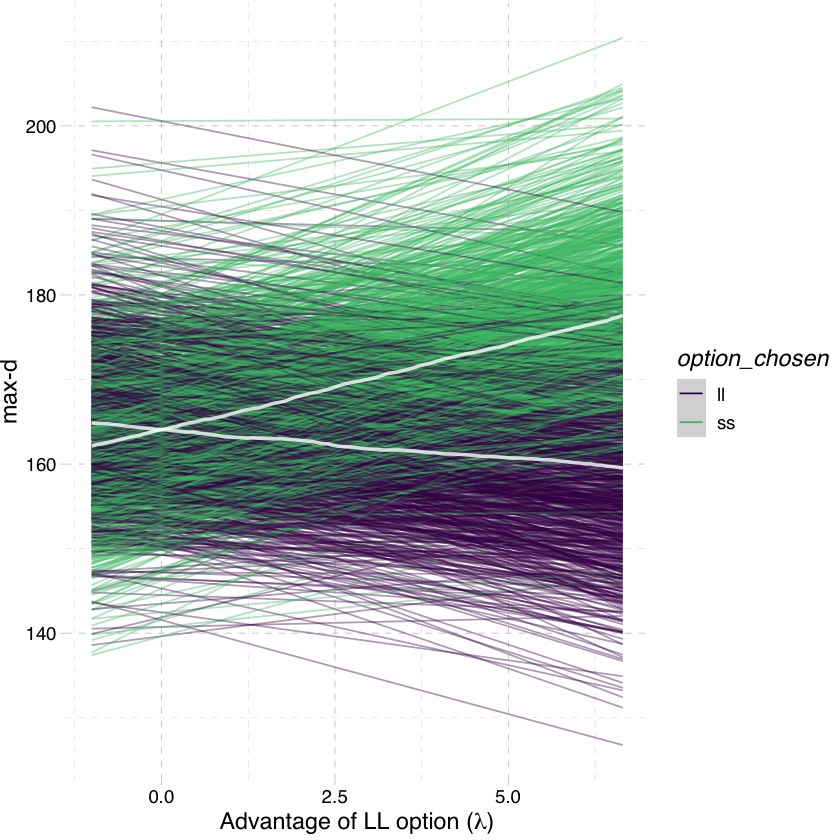

In [38]:
# spaghetti(rt_bf$models$m_inter, 'RT', 'RT')
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [39]:
m <- as.mcmc(max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_mouse_no_com.csv")

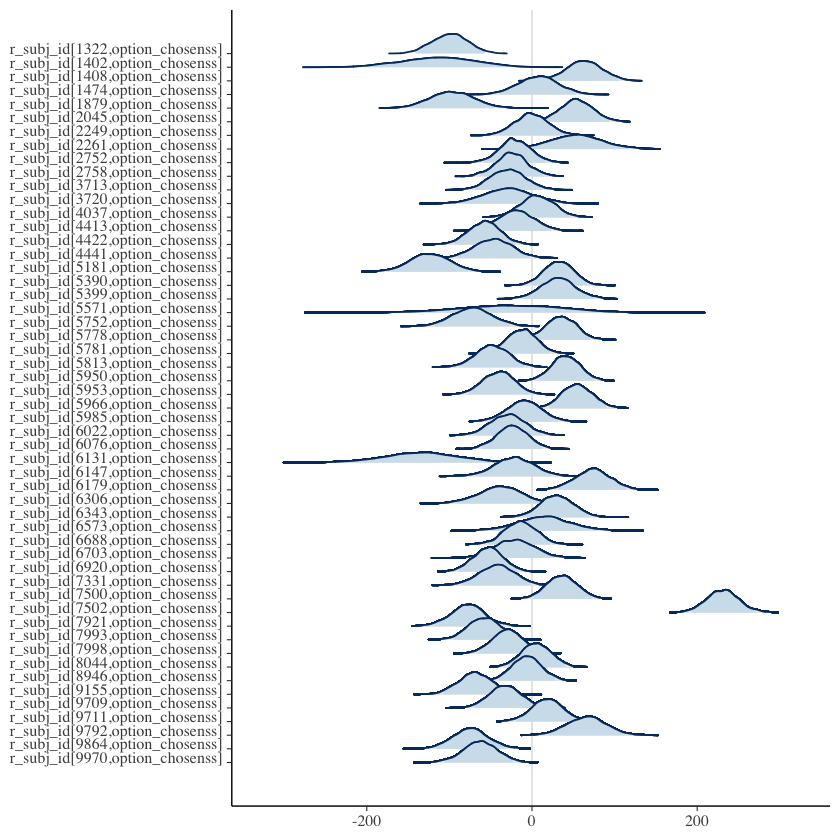

In [40]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Mouse data: RT

In [48]:
rt_bf <- run_analysis('RT', mouse_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '797c25c42186ff93b21e5d01422eb28f' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000257 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.57 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 31.8596 seconds (Warm-up)
Chain 1:                26.2974 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '3c149e5890a136f98e3a460a43e9eba9' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00021 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.1 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 16.9696 seconds (Warm-up)
Chain 1:                14.6282 seconds (Sampling)
Cha

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'be17b3a33f4c9d3ed7604ac0c3eaf4ef' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.76994 seconds (Warm-up)
Chain 1:                3.74803 seconds (Sampling)
Ch

In [49]:
rt_bf$bf

[,1]     [,2]         [,3]        
[1,] 36924858 7.816496e+18 191684334350

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


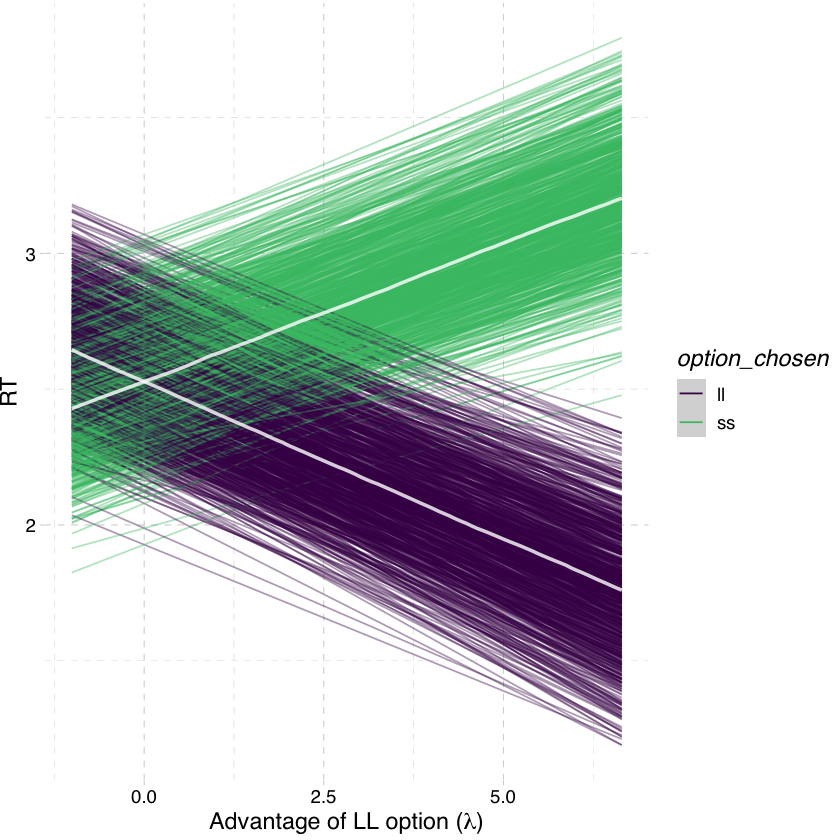

In [50]:
spaghetti(rt_bf$models$m_inter, 'RT', 'RT')

In [51]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "RT_mouse_all_coeffs.csv")

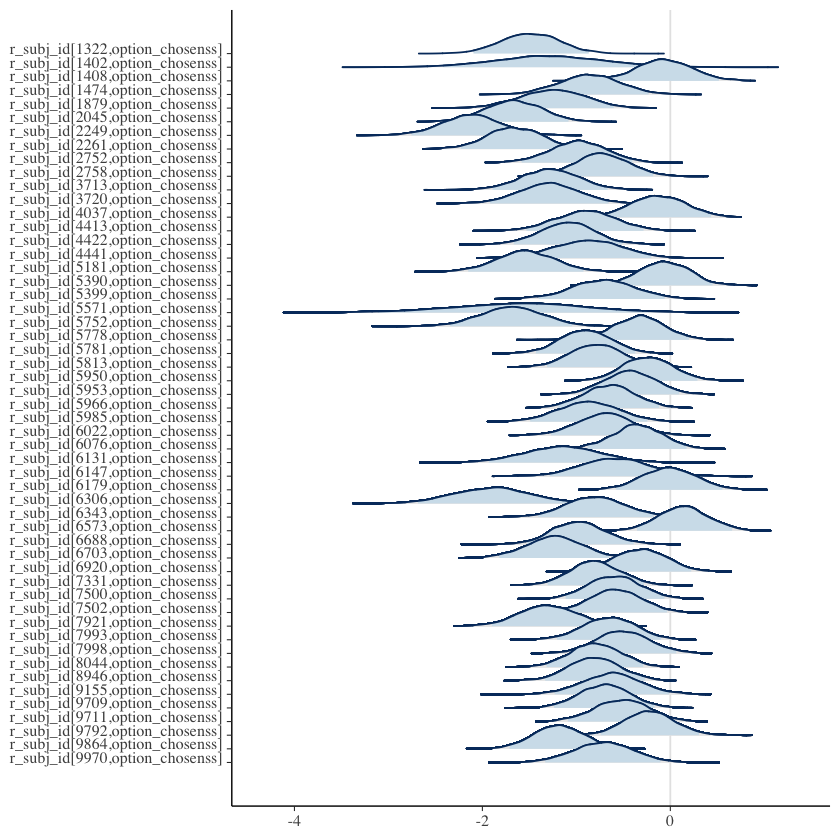

In [52]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Walking data: max-d without CoM

In [53]:
max_d_bf <- run_analysis('max_d', walking_data_no_com, 0.707)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling



SAMPLING FOR MODEL '95cac8b00bc525d091b153bff756db5e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000244 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.44 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 34.9307 seconds (Warm-up)
Chain 1:                16.817 seconds (Sampling)
Ch

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling



SAMPLING FOR MODEL '27c3e49e8b5dd0e24f6c023c670266bc' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000185 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.85 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 23.1462 seconds (Warm-up)
Chain 1:                15.5404 seconds (Sampling)
C

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling



SAMPLING FOR MODEL 'e471845673ed1740f839e3fc5f60b105' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 6.37282 seconds (Warm-up)
Chain 1:                4.17514 seconds (Sampling)
Ch

In [54]:
#     bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
max_d_bf$bf

[,1]         [,2]        [,3]    
[1,] 2.402507e+58 3.47433e+65 13910306

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


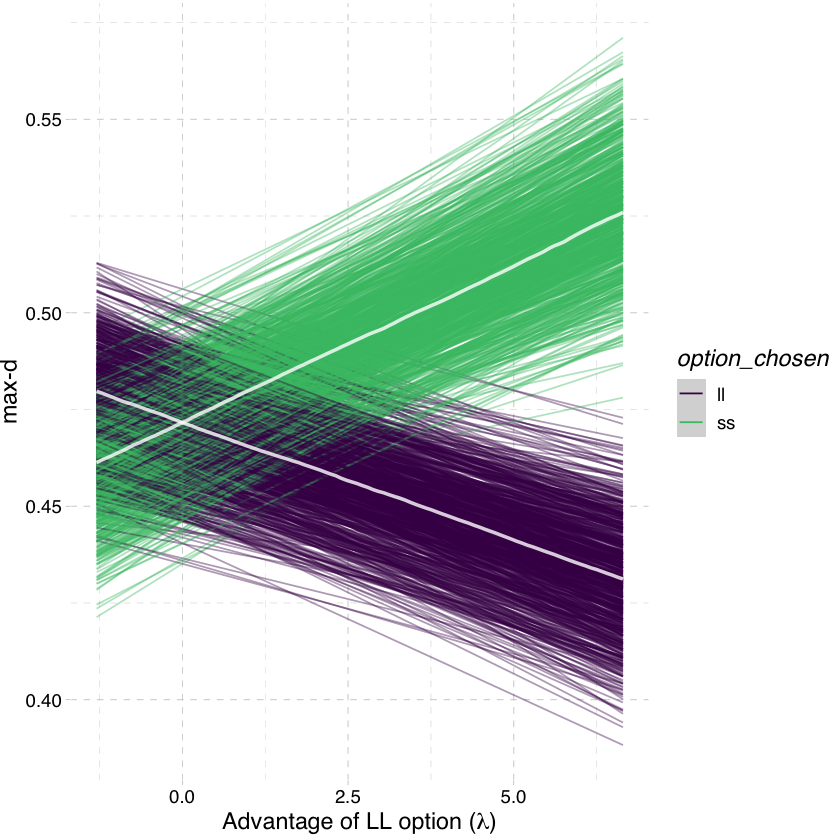

In [55]:
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [57]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_walking_no_com.csv")

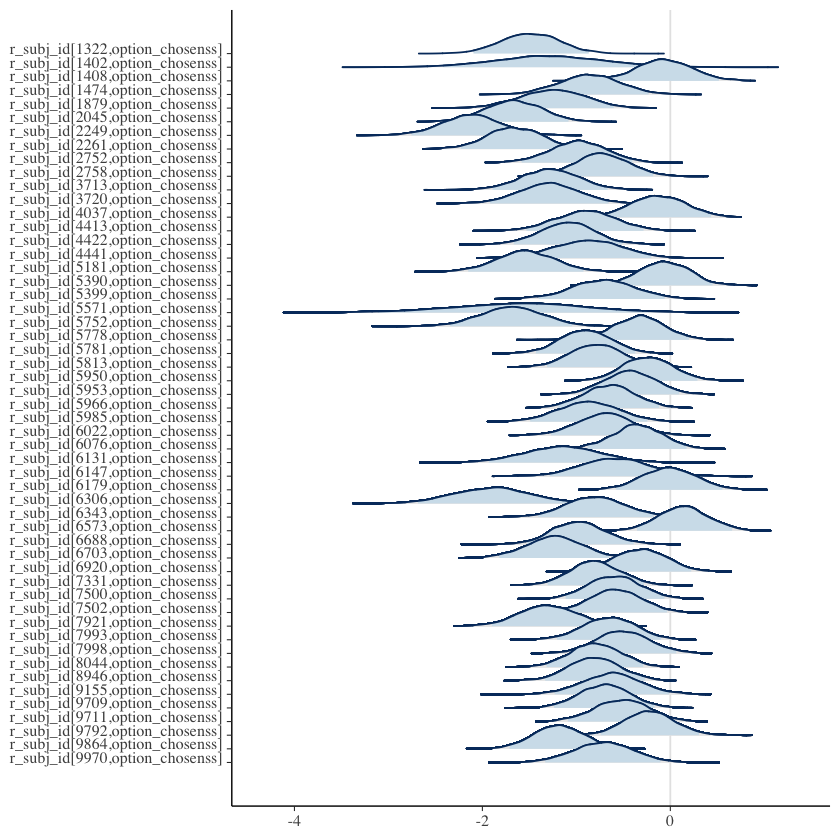

In [58]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Walking data: RT

In [59]:
rt_bf <- run_analysis('RT', walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'fed15a795f3a6cdd8dee64bee5779364' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000236 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.36 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 40.0851 seconds (Warm-up)
Chain 1:                23.2148 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'd98e35438d4487cac23374fa66bc1b8e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000176 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.76 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 23.8766 seconds (Warm-up)
Chain 1:                19.92 seconds (Sampling)
Cha

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '66af642df4752983c37bb5e7b69c034d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 5.02998 seconds (Warm-up)
Chain 1:                4.29422 seconds (Sampling)
Ch

In [61]:
rt_bf$bf

[,1]        [,2]         [,3]    
[1,] 1.45266e+11 1.074926e+16 75328.52

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


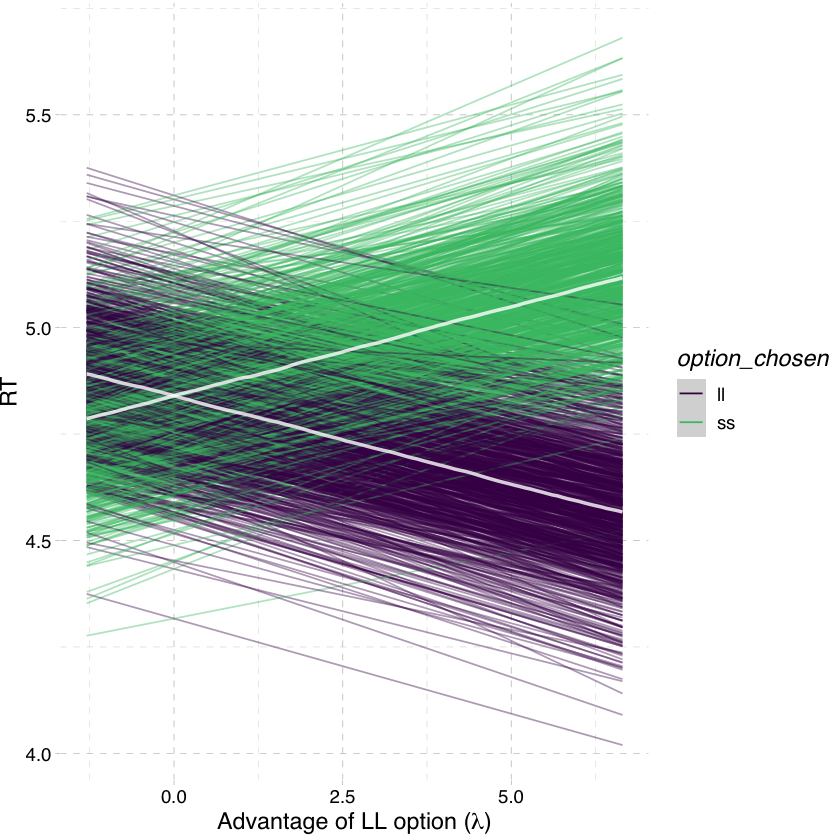

In [62]:
spaghetti(rt_bf$models$m_inter, 'RT', 'RT')

In [63]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "RT_walking_all_coeffs.csv")

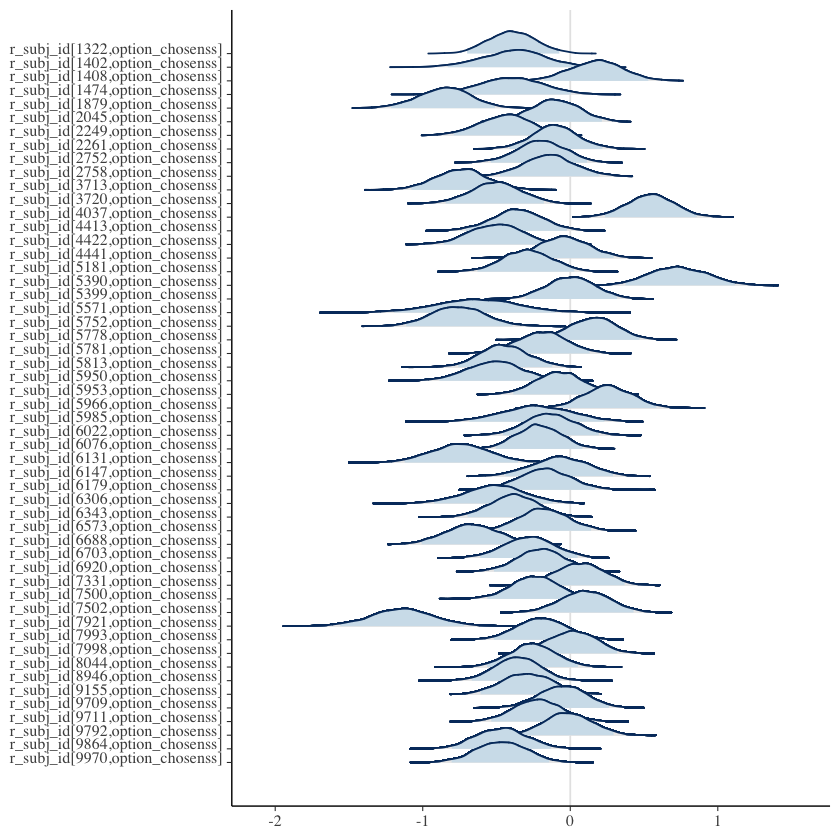

In [64]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

In [60]:
# hpd_inter<-HPDinterval(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE))

# mcmc_areas_ridges(as.matrix(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE)), regex_pars = "b_Lambda", prob=0.95)
# hpd_inter[c('b_Lambda:choiceLL', 'b_Lambda:choiceSS'),]